In [48]:
%matplotlib inline

# import libraries
import collections
import hashlib
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tag import pos_tag, map_tag
from os import path
import pandas as pd
from imageio import imread
import string
import random
import re
from wordcloud import WordCloud, STOPWORDS

In [49]:
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple wordcloud

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [50]:
# load data
anorexiaSubreddits = pd.read_csv("/Users/janice/Documents/aip_data/subreddits_anorexia.csv", encoding='ISO-8859-1')
obesitySubreddits = pd.read_csv("/Users/janice/Documents/aip_data/subreddits_obesity.csv", encoding='ISO-8859-1')
bothSubreddits = pd.read_csv("/Users/janice/Documents/aip_data/subreddits_both.csv", encoding='ISO-8859-1')

In [51]:

# apply hash function to author column in each dataset
anorexia_authors = anorexiaSubreddits.drop_duplicates(subset="author")['author'].apply(lambda a: hashlib.md5(a.encode()).hexdigest()).to_frame()
obesity_authors = obesitySubreddits.drop_duplicates(subset="author")['author'].apply(lambda a: hashlib.md5(a.encode()).hexdigest()).to_frame()
both_authors = bothSubreddits.drop_duplicates(subset="author")['author'].apply(lambda a: hashlib.md5(a.encode()).hexdigest()).to_frame()

In [52]:
anorexiaSubreddits['hashedAuthors'] = anorexia_authors
obesitySubreddits['hashedAuthors'] = obesity_authors
bothSubreddits['hashedAuthors'] = both_authors

In [53]:
# print example of anorexia_authors (hashed)
anorexia_authors.head()

,author
0,2e3cea450d14a67fac90de804c3984e0
1,9c02696b2e66a443afca156e917e03eb
2,87774818e97b0deba1982e3cf1d2d2e7
3,4391f26dc3b679280b2d091960f1f73c
4,ce035158b46aed8af92168dd6fa32ffa


# Analysis on Anorexia-Related Subreddits

In [54]:
# print first 10 rows of anorexia-related subreddits
# (minus original author column)
anorexiaSubreddits[["hashedAuthors", "body", "subreddit", "subreddit_id", "score"]].head()

,hashedAuthors,body,subreddit,subreddit_id,score
0,2e3cea450d14a67fac90de804c3984e0,"""Anorexia survivor"". How many people do actual...",TumblrInAction,t5_2vizz,2
1,9c02696b2e66a443afca156e917e03eb,Feminism. I thought it was all bra-burning ma...,AskReddit,t5_2qh1i,2
2,87774818e97b0deba1982e3cf1d2d2e7,This sounds like a bulimia/anorexia issue rath...,TalesFromYourServer,t5_2v480,11
3,4391f26dc3b679280b2d091960f1f73c,Work on the depression primarily. Its likely t...,AskReddit,t5_2qh1i,2
4,ce035158b46aed8af92168dd6fa32ffa,"Much like with ""curves"" and ""anorexia"", fat pe...",fatlogic,t5_2wyxm,11


In [55]:
# most common subreddits posted to
anorexiaSubreddits["subreddit"].value_counts()[:10]

fatpeoplehate          251
AskReddit              214
fatlogic               207
relationships           74
TwoXChromosomes         32
WTF                     30
raisedbynarcissists     26
Fitness                 25
AskWomen                24
EatingDisorders         24
Name: subreddit, dtype: int64

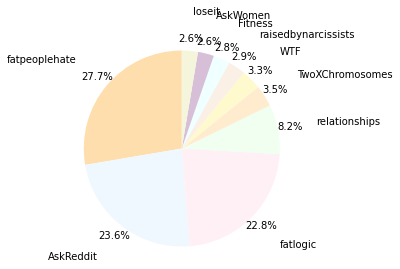

In [56]:
labels = "fatpeoplehate", "AskReddit", "fatlogic", "relationships", "TwoXChromosomes", "WTF", "raisedbynarcissists", "Fitness", "AskWomen", "loseit"
sizes = [251, 214, 207, 74, 32, 30, 26, 25, 24, 24]
colors = ["navajowhite", "aliceblue", "lavenderblush", "honeydew","blanchedalmond", "lemonchiffon","linen", "azure", "thistle", "beige"]
plt.pie(sizes, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=False, startangle=90, pctdistance=1.13, labeldistance=1.4)
plt.axis('equal')
plt.show()

In [57]:
# map author to body of text
scoreDict = anorexiaSubreddits.set_index('author')['body'].to_dict()

In [58]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/janice/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/janice/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [59]:
# strip punctuation from all body comments
bodyList = []
for val in anorexiaSubreddits["body"]:
    val = re.sub("[^a-zA-Z]+", " ", val)
    bodyList.append(val)

# tokenize each work, using nltk_tokenize
tokenList = []
for sentence in bodyList:
    tokens = nltk.word_tokenize(sentence)
    tokenList.append(tokens)

# add POS tags to words
taggedList = []
for item in tokenList:
    item = pos_tag(item)
    taggedList.append(item)
    #taggedList.append([(word, map_tag('en-ptb', 'universal', tag)) for word, tag in pos_tag(item)])
#print(taggedList)

# choose the most relevant words to consider,
# according to tags
relevantList = []
count = 0
for i in taggedList:
    for j in i:
        #if j[1] == "JJ" or j[1] == "JJR" or j[1] == "JJS" or j[1] == "NN" or j[1] == "RBR" or j[1] == "RBS" or j[1] == "RB" or j[1] == "VB" or j[1] == "VBD" or j[1] == "VBG":
        if j[1] == "JJ" or j[1] == "JJR" or j[1] == "JJS" or j[1] == "RBR" or j[1] == "RBS" or j[1] == "RB":
            relevantList.append(j[0].lower()) # it seems as if adjectives and adverbs are the most telling
            
# remove stopwords
finalList = [word for word in relevantList if word not in stopwords.words('english')]

fdist = FreqDist(finalList)
common = fdist.most_common()[0:101] # not including "anorexia"
uncommon = list(reversed(fdist.most_common()))[:50]
print("These are the most common words:",common, "\n")
print("These are the most uncommon words:", uncommon, "\n")

These are the most common words: [('even', 405), ('also', 399), ('really', 382), ('anorexia', 336), ('much', 327), ('fat', 323), ('mental', 278), ('healthy', 253), ('still', 247), ('good', 237), ('never', 235), ('better', 207), ('well', 198), ('actually', 187), ('many', 164), ('always', 154), ('long', 145), ('bad', 142), ('normal', 139), ('enough', 136), ('right', 135), ('probably', 134), ('back', 131), ('first', 130), ('little', 125), ('pretty', 122), ('hard', 118), ('thin', 117), ('different', 116), ('less', 115), ('eating', 112), ('sure', 111), ('best', 111), ('anorexic', 110), ('ever', 108), ('able', 105), ('last', 104), ('high', 99), ('weight', 96), ('maybe', 93), ('least', 92), ('skinny', 91), ('great', 90), ('often', 87), ('old', 85), ('unhealthy', 85), ('real', 81), ('physical', 80), ('medical', 79), ('almost', 78), ('underweight', 78), ('sometimes', 78), ('away', 77), ('serious', 75), ('wrong', 74), ('likely', 73), ('obese', 73), ('far', 73), ('big', 71), ('else', 70), ('happy

In [60]:
newCommon = [('anorexia', 336), ('fat', 323), ('mental', 278), ('healthy', 253), \
              ('bad', 142), ('normal', 139), ('enough', 136), ('first', 130), ('little', 125), ('pretty', 122), ('hard', 118), ('thin', 117), ('different', 116), ('less', 115), ('eating', 112), ('best', 111), ('anorexic', 110), ('high', 99), ('weight', 96), ('maybe', 93), ('least', 92), ('skinny', 91), ('great', 90), ('unhealthy', 85), ('old', 85), ('real', 81), ('physical', 80), ('medical', 79), ('underweight', 78), ('away', 77), ('serious', 75), ('wrong', 74), ('obese', 73), ('far', 73),  ('big', 71),  ('diet', 68), ('happy', 68), ('definitely', 67), ('overweight', 65), ('due', 64), ('similar', 63), ('low', 62), ('full', 62), ('whole', 62), ('social', 60), ('especially', 60), ('small', 58), ('possible', 58), ('completely', 57), ('seriously', 55), ('however', 55), ('already', 55), ('certain', 54), ('important', 52), ('rather', 52), ('worse', 52), ('finally', 50), ('literally', 49), ('severe', 49), ('obviously', 49), ('common', 48), ('psychological', 48), ('new', 47), ('human', 47), ('absolutely', 45), ('yet', 45), ('true', 45), ('nice', 45), ('quite', 44), ('strong', 44), ('honestly', 44), ('gt', 43), ('self', 43), ('later', 42)] 

completeText = ""
for key, val in newCommon:
    completeText += (key + " ") * val

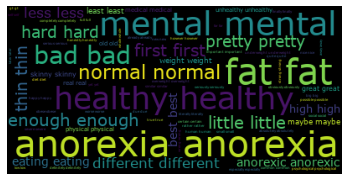

In [61]:
text = completeText
wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                      relative_scaling = 0.5,
                      stopwords = 'to of'
                      ).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [62]:
# anecdotes containing the most common words
listOfWords = ["eating", "weight", "pretty", "weight"]
count = 0
for sentence in bodyList:
    if all(word in sentence for word in listOfWords):
        if count <= 5:
            print(sentence + "\n")
            count += 1

I was diagnosed by Anorexia bulimic subtype before I was diagnosed with Bipolar I I ate an apple a day and spent hours a day on the treadmill everyday or I wouldn t be able to sleep or concentrate on anything I had a hard time sticking to my Lithium regiment because I was so terrified of gaining weight Thankfully Lamictal does a pretty good job of quieting both my bipolar and eating disorder I ve been told that anorexia occurs pretty frequently along side bipolar because of the effect that starvation and overexercising has in stabilizing our moods not to mention creating a sense of control when we re stuck in shitty situations we can t escape from Also if you want to read a really good book having to do mostly about Bipolar but also EDs I d read Madness by Marya Hornbacher really good book but sad as well I was surprised by how much I could empathize with her it really helped me come to terms with my diagnosis and feel less alone 

I m glad You have posted this because I am having the 

In [63]:

scoreDict = anorexiaSubreddits.set_index('score')['body'].to_dict()

topScoreCount = 0
for score, body in sorted(scoreDict.items(),reverse = True):
    if topScoreCount != 5:
        print(score, ":" ,body, "\n")
        topScoreCount += 1
print ("---------------------------------------------------------------------------------------------------------------------")        
bottomScoreCount = 0
for score, body in sorted(scoreDict.items()):
    if bottomScoreCount != 5:
        print(score, ":" ,body, "\n")
        bottomScoreCount += 1

779 : The yuppie, neo-hippie, ultra-liberals and their fear of GMO, preservatives and non-organic food. 

This is a completely uneducated opinion that I base off nothing but it seems like a money making scheme of bullshit. I mean, if you eat your fair share of veggies, avoid fried foods and cakes/cookies, stay around 1200 calories a day, exercise regularly and take vitamins I doubt your health will be suffering much because you ate a non organic carrot. 

EDIT: Apparently 1200 is anorexia. I got that number from a weight loss app. So yeah, 2000 calories or more if you are super tall, my bad.  

418 : Wow. This is awful. Regardless of whether or not she will develop a clinical eating disorder, your husband is abusive, and damaging her self image when she's at an age that it's under attack by peers and the media.

First thing I'd do is talk with her pediatrician. He or she can help you plan a strategy including medical and psychological (therapy) help for your daughter, and couples or fa

# Analysis on Obesity-Related Subreddits


In [64]:
# print first five values of dataset
obesitySubreddits[["hashedAuthors", "body", "subreddit", "subreddit_id", "score"]].head(5)

,hashedAuthors,body,subreddit,subreddit_id,score
0,d9ccb6eaa68d1b3ea3dd432e48c6bfff,I'M pissed that the dancing girl fat girl got ...,RagenChastain,t5_323a3,4.0
1,24654918653efa65253028b1a8474c61,Well..when someone is obese its obvious when y...,TumblrInAction,t5_2vizz,1.0
2,f259124ebfbfa451037cfe9639ca73c6,"For the last 100,000 years of humanity obesity...",sex,t5_2qh3p,5.0
3,e4ed7d00769cb2ecc997d94c60d5dcd3,The EU courts now says that obesity is a disab...,videos,t5_2qh1e,1.0
4,9bffc299b5a7a7f8980c28564ca12687,Its amazing how obesity ages people. She looks...,fatpeoplehate,t5_2x9xz,2.0


In [65]:
# most common subreddits posted to
obesitySubreddits["subreddit"].value_counts()[:10]

fatpeoplehate     1055
AskReddit         1041
fatlogic           953
funny              191
todayilearned      165
science            152
WTF                142
worldnews          130
Fitness            129
TumblrInAction     128
Name: subreddit, dtype: int64

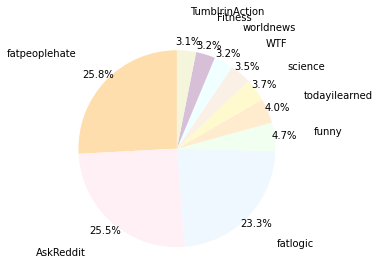

In [66]:
labels = "fatpeoplehate", "AskReddit", "fatlogic", "funny", "todayilearned", "science", "WTF", "worldnews", "Fitness", "TumblrinAction"
sizes = [1055, 1041, 953, 191, 165, 152, 142, 130, 129, 128]
colors = ["navajowhite", "lavenderblush", "aliceblue", "honeydew", "blanchedalmond", "lemonchiffon","linen", "azure", "thistle", "beige"]
plt.pie(sizes, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=False, startangle=90, pctdistance=1.1, labeldistance=1.4)
plt.axis('equal')
plt.show()

In [67]:
#create dictionary to match author with body (aka: Who wrote what?)
scoreDict = obesitySubreddits.set_index('author')['body'].to_dict()

In [68]:
# remove punctuation from body
bodyList = []
for val in obesitySubreddits["body"]:
    val = re.sub("[^a-zA-Z]+", " ", val)
    bodyList.append(val)

# tokenize each work, using nltk_tokenize
tokenList = []
for sentence in bodyList:
    tokens = nltk.word_tokenize(sentence)
    tokenList.append(tokens)

# add POS tags to words
taggedList = []
for item in tokenList:
    item = pos_tag(item)
    taggedList.append(item)
    #taggedList.append([(word, map_tag('en-ptb', 'universal', tag)) for word, tag in pos_tag(item)])
#print(taggedList)

# choose the most relevant words to consider,
# according to tags
relevantList = []
count = 0
for i in taggedList:
    for j in i:
        #if j[1] == "JJ" or j[1] == "JJR" or j[1] == "JJS" or j[1] == "NN" or j[1] == "RBR" or j[1] == "RBS" or j[1] == "RB" or j[1] == "VB" or j[1] == "VBD" or j[1] == "VBG":
        if j[1] == "JJ" or j[1] == "JJR" or j[1] == "JJS" or j[1] == "RBR" or j[1] == "RBS" or j[1] == "RB":
            relevantList.append(j[0].lower()) # it seems as if adjectives and adverbs are the most telling
            
# remove stopwords
finalList = [word for word in relevantList if word not in stopwords.words('english')]

fdist = FreqDist(finalList)
common = fdist.most_common()[0:101] # not including "anorexia"
uncommon = list(reversed(fdist.most_common()))[:50]
print("These are the most common words:",common, "\n")
print("These are the most uncommon words:", uncommon, "\n")

These are the most common words: [('fat', 2980), ('obese', 1831), ('also', 1552), ('even', 1535), ('much', 1489), ('healthy', 1412), ('really', 1245), ('good', 1102), ('many', 1027), ('still', 885), ('well', 881), ('high', 839), ('actually', 802), ('less', 779), ('bad', 734), ('better', 642), ('never', 640), ('unhealthy', 621), ('long', 570), ('low', 557), ('diet', 557), ('weight', 543), ('overweight', 539), ('probably', 521), ('first', 504), ('pretty', 490), ('medical', 486), ('little', 484), ('right', 475), ('always', 461), ('back', 452), ('enough', 450), ('poor', 448), ('different', 447), ('sure', 437), ('however', 421), ('likely', 416), ('normal', 410), ('far', 400), ('wrong', 396), ('due', 393), ('hard', 376), ('lower', 365), ('ever', 355), ('big', 353), ('instead', 347), ('higher', 347), ('least', 346), ('often', 336), ('great', 331), ('real', 322), ('whole', 315), ('else', 313), ('www', 310), ('best', 304), ('new', 301), ('maybe', 300), ('full', 300), ('physical', 296), ('true',

In [69]:
newCommon = [('fat', 2980), ('obese', 1831), ('healthy', 1412),  \
             ('unhealthy', 621), ('diet', 557), ('weight', 543),\
             ('overweight', 539), ('pretty', 490), ('medical', 486), ('little', 484), \
              ('poor', 448), ('different', 447),  ('normal', 410), ('far', 400), ('wrong', 396), ('due', 393), ('hard', 376), ('lower', 365), ('ever', 355), ('big', 353), ('higher', 347), ('instead', 347), ('least', 346), ('often', 336), ('great', 331), ('real', 322), ('whole', 315), ('else', 313), ('www', 310), ('best', 304), ('new', 301), ('maybe', 300), ('full', 300), ('true', 296), ('physical', 296), ('last', 291), ('able', 288), ('especially', 286), ('human', 281), ('old', 275), ('rather', 273), ('already', 273), ('mental', 272), ('thin', 269), ('social', 268), ('large', 265), ('almost', 263), ('certain', 262), ('huge', 261), ('simply', 256), ('http', 256), ('average', 255), ('important', 250), ('general', 243), ('american', 237), ('free', 237), ('public', 230), ('possible', 228), ('worse', 227), ('gt', 227), ('completely', 225), ('fast', 224), ('usually', 223), ('u', 222), ('common', 221), ('small', 219), ('attractive', 218), ('obesity', 216), ('serious', 216), ('yet', 213), ('skinny', 209), ('easy', 206), ('personal', 204), ('happy', 203), ('quite', 198), ('extra', 198)]

completeText = ""
for key, val in newCommon:
    completeText += (key + " ") * val

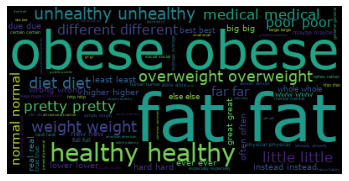

In [70]:
text = completeText
wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                      relative_scaling = 0.5,
                      stopwords = 'to of'
                      ).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [71]:
# anecdote
listOfWords = ["obese", "fat", "unhealthy", "skinny"]
count = 0
for sentence in bodyList:
    if all(word in sentence for word in listOfWords):
        if count <= 5:
            print(sentence + "\n")
            count += 1

Reading your last paragraph I feel your heart in the right place and I agree that it s not okay to bully someone However having empathy doesn t make excuses and enabling acceptable You are in denial and trying to come up with reasons why a person is obese Genetics determine where fat is distributed and may determine how mentally hungry you are It s very uncommon for a person to become obese due to illness or medication Genetics doesn t make fat out of thin air and unless we re overeating our bodies don t accumulate and hold onto fat forever fat is our energy reserves You say that income have an effect on weight so that s saying that exercising gym membership and a low calorie diet kale are what makes a person slim not genetics I m a young Asian woman We re apparently known to be naturally skinny That s complete nonsense When I consume more than my TDEE I get fat I m underweight now because I m not consuming many calories You ll see the opposite in developing countries where the fatter 

In [72]:
scoreDict = obesitySubreddits.set_index('score')['body'].to_dict()

topScoreCount = 0
for score, body in sorted(scoreDict.items(),reverse = True):
    if topScoreCount != 5:
        print(score, ":" ,body, "\n")
        topScoreCount += 1
print ("---------------------------------------------------------------------------------------------------------------------")        
bottomScoreCount = 0
for score, body in sorted(scoreDict.items()):
    if bottomScoreCount != 5:
        print(score, ":" ,body, "\n")
        bottomScoreCount += 1

3265.0 : Agreed. If they were just anti fat-shaming, I'd be on board. However, fat acceptance activists like to cherry-pick medical studies and downplay the serious health effects associated with obesity, which is messed up.  

821.0 : The problem isn't that obesity runs in your family....it's the nobody runs in your family.  

541.0 : Maybe morbid obesity is the first thing on the chart because weighing you is the *first thing you do at the doctor's office*.  

387.0 : Written by an Englishman, about the English equivalent of Middle Earth, played by Englishmen in the adaptions.

The second breakfast seems English, what with rising obesity and all. 

323.0 : My Mother died at age 49.  She was a terrible cook.  I miss her like crazy, of course...but I will never miss her cooking.  I never knew food could taste good until I started going out.

Actually, I figured out years later that my family suffered from obesity, heart problems and diabetes.  My Mom tried to keep the food as healthy a

# Analysis on Eating Disorder-Related Subreddts (including Anorexia, Obesity, and other EDs)

In [73]:
# print first five values of dataset
bothSubreddits[["hashedAuthors", "body", "subreddit", "subreddit_id", "score"]].head(5)

,hashedAuthors,body,subreddit,subreddit_id,score
0,24654918653efa65253028b1a8474c61,Well..when someone is obese its obvious when y...,TumblrInAction,t5_2vizz,1
1,8b0d6fbd30e0beeab6189e26bdd67e45,"&gt;Clean eating means not overly processed, t...",Fitness,t5_2qhx4,7
2,0db37b1e34902f5f93c5499c0fe8b9a8,"""You're gaining weight!""\rBecause you were a G...",raisedbynarcissists,t5_2we9n,9
3,f259124ebfbfa451037cfe9639ca73c6,"For the last 100,000 years of humanity obesity...",sex,t5_2qh3p,5
4,e4ed7d00769cb2ecc997d94c60d5dcd3,The EU courts now says that obesity is a disab...,videos,t5_2qh1e,1


In [74]:
# most common subreddits posted to
bothSubreddits["subreddit"].value_counts()[:10]

AskReddit         2119
fatpeoplehate     1801
fatlogic          1410
Fitness            361
funny              321
relationships      298
WTF                268
todayilearned      229
loseit             221
TumblrInAction     186
Name: subreddit, dtype: int64

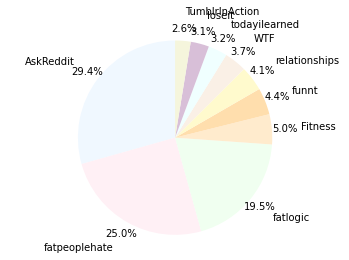

In [75]:
labels = "AskReddit", "fatpeoplehate", "fatlogic", "Fitness", "funnt", "relationships", "WTF", "todayilearned", "loseit", "TumblrInAction"
sizes = [2119, 1801, 1410, 361, 321, 298, 268, 229, 221, 186]
colors = ["aliceblue", "lavenderblush", "honeydew","blanchedalmond", "navajowhite", "lemonchiffon","linen", "azure", "thistle", "beige"]
plt.pie(sizes, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=False, startangle=90, pctdistance=1.13, labeldistance=1.3)
plt.axis('equal')
plt.show()

In [76]:
scoreDict = bothSubreddits.set_index('author')['body'].to_dict()

In [77]:
# remove punctuation from body
bodyList = []
for val in bothSubreddits["body"]:
    val = re.sub("[^a-zA-Z]+", " ", val)
    bodyList.append(val)

# tokenize each work, using nltk_tokenize
tokenList = []
for sentence in bodyList:
    tokens = nltk.word_tokenize(sentence)
    tokenList.append(tokens)

# add POS tags to words
taggedList = []
for item in tokenList:
    item = pos_tag(item)
    taggedList.append(item)
    #taggedList.append([(word, map_tag('en-ptb', 'universal', tag)) for word, tag in pos_tag(item)])
#print(taggedList)

# choose the most relevant words to consider,
# according to tags
relevantList = []
count = 0
for i in taggedList:
    for j in i:
        #if j[1] == "JJ" or j[1] == "JJR" or j[1] == "JJS" or j[1] == "NN" or j[1] == "RBR" or j[1] == "RBS" or j[1] == "RB" or j[1] == "VB" or j[1] == "VBD" or j[1] == "VBG":
        if j[1] == "JJ" or j[1] == "JJR" or j[1] == "JJS" or j[1] == "RBR" or j[1] == "RBS" or j[1] == "RB":
            relevantList.append(j[0].lower()) # it seems as if adjectives and adverbs are the most telling
            
# remove stopwords
finalList = [word for word in relevantList if word not in stopwords.words('english')]

fdist = FreqDist(finalList)
common = fdist.most_common()[0:151] # not including "anorexia"
uncommon = list(reversed(fdist.most_common()))[:50]
print("These are the most common words:",common, "\n")
print("These are the most uncommon words:", uncommon, "\n")

These are the most common words: [('obese', 8172), ('fat', 4486), ('even', 2909), ('really', 2779), ('also', 2672), ('much', 2622), ('healthy', 2316), ('still', 2060), ('good', 1999), ('many', 1574), ('never', 1558), ('well', 1530), ('actually', 1379), ('morbidly', 1266), ('better', 1245), ('bad', 1164), ('less', 1121), ('overweight', 1108), ('probably', 1072), ('first', 1027), ('long', 1024), ('high', 1021), ('back', 1011), ('little', 1007), ('pretty', 1006), ('always', 997), ('right', 971), ('unhealthy', 891), ('sure', 886), ('normal', 845), ('enough', 835), ('different', 800), ('ever', 796), ('hard', 791), ('weight', 784), ('big', 745), ('diet', 717), ('least', 669), ('maybe', 657), ('best', 652), ('old', 645), ('wrong', 645), ('thin', 640), ('far', 625), ('however', 621), ('u', 620), ('able', 619), ('last', 615), ('low', 612), ('anorexic', 603), ('real', 600), ('skinny', 597), ('great', 594), ('likely', 588), ('eating', 576), ('often', 571), ('else', 571), ('mental', 561), ('alread

In [78]:

newCommon = [('obese', 8172), ('fat', 4486), ('healthy', 2316), ('still', 2060), ('good', 1999), ('never', 1558), ('morbidly', 1266), ('better', 1245), ('bad', 1164), ('less', 1121), ('overweight', 1108), ('probably', 1072), ('first', 1027), ('long', 1024), ('high', 1021), ('back', 1011), ('little', 1007), ('pretty', 1006), ('always', 997), ('right', 971), ('unhealthy', 891), ('sure', 886), ('normal', 845), ('enough', 835), ('different', 800), ('ever', 796), ('hard', 791), ('weight', 784), ('big', 745), ('diet', 717), ('least', 669), ('maybe', 657), ('best', 652), ('wrong', 645), ('old', 645), ('thin', 640), ('far', 625), ('however', 621), ('u', 620), ('able', 619), ('last', 615), ('low', 612), ('anorexic', 603), ('real', 600), ('skinny', 597), ('great', 594), ('likely', 588), ('eating', 576), ('else', 571), ('often', 571), ('mental', 561), ('already', 552), ('whole', 540), ('medical', 538), ('instead', 515), ('almost', 515), ('due', 510), ('poor', 507), ('new', 500), ('full', 492), ('true', 484), ('definitely', 474), ('especially', 465), ('rather', 460), ('small', 456), ('physical', 444), ('usually', 437), ('average', 423), ('attractive', 415), ('huge', 413), ('completely', 413), ('away', 411), ('happy', 406), ('large', 400), ('yet', 395), ('http', 386), ('possible', 386), ('important', 385), ('free', 370), ('easy', 369), ('quite', 367), ('sometimes', 364), ('serious', 359), ('simply', 356), ('human', 352), ('lbs', 351), ('literally', 343), ('social', 342), ('lower', 341), ('extremely', 340), ('higher', 339), ('certain', 331), ('worse', 328), ('general', 328), ('seriously', 325), ('gt', 319), ('next', 317), ('short', 312), ('absolutely', 310), ('fine', 309), ('obviously', 306), ('young', 300), ('extra', 300), ('fit', 298), ('fast', 298), ('www', 298), ('similar', 297), ('difficult', 293), ('super', 293), ('personal', 291), ('common', 284), ('american', 281), ('basically', 280), ('longer', 278), ('beautiful', 276), ('stupid', 276), ('single', 275), ('exactly', 272), ('ago', 271), ('later', 266), ('honestly', 266), ('generally', 263), ('easier', 263), ('active', 262), ('entire', 261), ('clearly', 257), ('public', 255), ('actual', 255), ('white', 252), ('black', 249), ('nice', 248), ('early', 241), ('physically', 241), ('certainly', 241), ('simple', 240), ('strong', 239), ('together', 239), ('underweight', 237), ('mostly', 236), ('totally', 231), ('daily', 231), ('alone', 230), ('healthier', 223)]
completeText = ""
for key, val in newCommon:
    completeText += (key + " ") * val

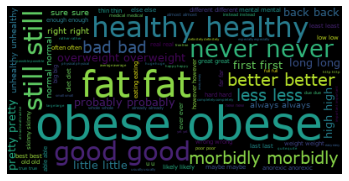

In [79]:

text = completeText
wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                      relative_scaling = 0.5,
                      stopwords = 'to of'
                      ).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [80]:
# anecdote
listOfWords = ["fat", "healthy", "morbidly", "overweight"]
count = 0
for sentence in bodyList:
    if all(word in sentence for word in listOfWords):
        if count <= 5:
            print(sentence + "\n")
            count += 1

I was lbs for most of my teenage early adulthood life I was lbs overweight Even when I was fat I hated fatties I hated myself because I knew how fucking pathetic I was I m down lbs now hoping to do a full lbs drop by late spring Now that I m the weight of a normal fucking human being I hate fatties even more They give me an unhealthy amount of rage The ones that bother me the most though are people are are maybe lbs overweight rocketing for obesity I work retail so I get hundreds of people a day and I can tell you that there is a heavy fucking positive correlation between the amount of crap food in the cart and the persons weight That and obese children I saw a morbidly obese toddler last month poor thing must have weighed close to lbs She was a waddling glob looking more like a supernatural monster than a human I had to excuse myself to the back and cried with utter rage at how her parents were ruining her fucking life before it even began I hate them more because I know becoming norm

In [81]:
scoreDict = bothSubreddits.set_index('score')['body'].to_dict()

topScoreCount = 0
for score, body in sorted(scoreDict.items(),reverse = True):
    if topScoreCount != 5:
        print(score, ":" ,body, "\n")
        topScoreCount += 1
print ("---------------------------------------------------------------------------------------------------------------------")        
bottomScoreCount = 0
for score, body in sorted(scoreDict.items()):
    if bottomScoreCount != 5:
        print(score, ":" ,body, "\n")
        bottomScoreCount += 1

3265 : Agreed. If they were just anti fat-shaming, I'd be on board. However, fat acceptance activists like to cherry-pick medical studies and downplay the serious health effects associated with obesity, which is messed up.  

Society, there's a difference 

1887 : That sounds like child abuse. How old were you when you found out she was doing it because of an eating disorder? 

1637 : Junk food and it's designed to be that way. I used to work with a guy who was morbidly obese. He was a compulsive eater. It was depressing to watch him eat food. It didn't make him happy. It didn't fill him up. It just temporarily took away that urge. 

1105 : go hire two morbidly obese people to have scatological sex in front of the camera and leave them that.  

---------------------------------------------------------------------------------------------------------------------
 

I got praised by people for my minimal effort because they simply noticed it.  I didn't have to seek out praise with some ri

In [87]:
import pandas as pd

anorexiaSubredditsLIWC = pd.read_csv("/Users/janice/Downloads/LIWC_subreddits_anorexia.txt", sep = "\t", encoding='ISO-8859-1')
obesitySubredditsLIWC = pd.read_csv("/Users/janice/Downloads/LIWC_subreddits_obesity.txt", sep = "\t", encoding='ISO-8859-1')

/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [88]:
# drop rows that contain NaN values
anorexiaSubredditsLIWC = anorexiaSubredditsLIWC.dropna()
anorexiaSubredditsLIWC = anorexiaSubredditsLIWC.drop(anorexiaSubredditsLIWC.index[[0]]) # remove row 0

# drop rows that contain NaN values
obesitySubredditsLIWC = obesitySubredditsLIWC.dropna()
obesitySubredditsLIWC = obesitySubredditsLIWC.drop(obesitySubredditsLIWC.index[[0]]) #remove row 0

2021-11-02 22:18:32,331 INFO NumExpr defaulting to 8 threads.


In [89]:
anorexiaSubredditsLIWC.to_csv("LIWC_anorexia.csv", index=False)
obesitySubredditsLIWC.to_csv("LIWC_obesity.csv", index=False)

In [90]:
# load data
anorexiaLIWC = pd.read_csv("LIWC_anorexia.csv", encoding='ISO-8859-1')
obesityLIWC = pd.read_csv("LIWC_obesity.csv", encoding='ISO-8859-1')

In [91]:
anorexiaLIWC.head()


,Source (A),Source (B),Source (C),Source (D),Source (E),WC,Analytic,Clout,Authentic,Tone,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,sophistate_xx,Yup. They also put fat ones for Victorian (!!!...,fatpeoplehate,t5_2x9xz,16,52.0,73.90,57.63,83.83,5.37,...,5.77,0.0,1.92,0.00,5.77,0.0,7.69,0.00,3.85,0.0
1,probably_a_bitch,You know what? I can eat whatever I want and s...,fatpeoplehate,t5_2x9xz,5,144.0,8.65,7.25,53.52,15.92,...,0.69,0.0,0.00,0.69,0.00,0.0,1.39,4.86,0.00,0.0
2,GrandmasterSexay,"She's not even thin to the point on anorexia, ...",fatpeoplehate,t5_2x9xz,26,24.0,3.55,33.83,48.89,92.40,...,4.17,0.0,0.00,0.00,4.17,0.0,8.33,8.33,0.00,0.0
3,Pamzella,I was once for a year.... Dealing with anorex...,infertility,t5_2saej,1,46.0,28.96,6.42,80.16,93.61,...,4.35,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0
4,Trollhydra,Don't forget they tend to say something along ...,fatlogic,t5_2wyxm,22,41.0,6.73,11.14,71.40,25.77,...,4.88,0.0,0.00,0.00,0.00,0.0,4.88,4.88,0.00,0.0


In [92]:
columns = list(anorexiaLIWC.columns.values)[6:]


In [93]:
valueCount = {}
for item in columns:
    try:
        valueCount[item].add(anorexiaLIWC[item].values.sum())
    except:
        valueCount[item] = [anorexiaLIWC[item].values.sum()]
#print(valueCount)

In [94]:
# top 20 most dominant features
count = 0
for w in sorted(valueCount, key=valueCount.get, reverse=True):
    if count <= 20:
        print(w, valueCount[w])
        count += 1

Dic [58483.5]
function [34677.08]
Clout [31193.8]
Analytic [28160.690000000002]
Authentic [25525.41]
Tone [21786.04]
Sixltr [13836.21]
AllPunc [13439.1]
verb [12110.54]
WPS [10444.93]
pronoun [9959.320000000002]
cogproc [9390.13]
focuspresent [8392.650000000001]
prep [7852.76]
auxverb [6980.68]
bio [6576.85]
social [6106.84]
relativ [6084.960000000001]
ppron [5886.62]
Period [4911.52]
ingest [4662.65]


In [95]:
obesityLIWC.head()


,Source (A),Source (B),Source (C),Source (D),Source (E),WC,Analytic,Clout,Authentic,Tone,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,casiells,Well..when someone is obese its obvious when y...,TumblrInAction,t5_2vizz,1.0,39.0,3.37,96.34,17.46,2.70,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,2.56,0.0,0.0
1,Unbearable_facts,The EU courts now says that obesity is a disab...,videos,t5_2qh1e,1.0,17.0,73.36,72.17,6.20,25.77,...,0.0,0.0,0.0,5.88,0.0,0.0,0.0,0.00,0.0,0.0
2,skippyjohnjameson,Its amazing how obesity ages people. She looks...,fatpeoplehate,t5_2x9xz,2.0,16.0,22.13,96.95,74.76,99.00,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0
3,FormerSperm,Wouldn't be so slow if she didn't overeat to t...,fatpeoplehate,t5_2x9xz,3.0,13.0,3.37,1.07,1.40,25.77,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,15.38,0.0,0.0
4,ThickSantorum,"aka ""30 years ago"" before obesity was normal.",AskReddit,t5_2qh1i,-3.0,8.0,92.84,50.00,99.00,25.77,...,0.0,0.0,0.0,0.00,0.0,0.0,25.0,0.00,0.0,0.0


In [96]:
columns = list(obesityLIWC.columns.values)[6:]


In [97]:
valueCount = {}
for item in columns:
    try:
        valueCount[item].add(obesityLIWC[item].values.sum())
    except:
        valueCount[item] = [obesityLIWC[item].values.sum()]

In [98]:
# top 20 most dominant features
count = 0
for w in sorted(valueCount, key=valueCount.get, reverse=True):
    if count <= 20:
        print(w, valueCount[w])
        count += 1

Dic [281542.89]
Clout [172828.81]
Analytic [165695.77999999997]
function [162787.11]
Tone [110669.12]
Authentic [110572.48999999999]
Sixltr [69287.29]
AllPunc [61768.979999999996]
verb [53311.950000000004]
WPS [51200.83]
cogproc [45447.869999999995]
pronoun [41238.4]
focuspresent [40077.21]
prep [38902.46]
auxverb [33499.07]
relativ [33336.81]
bio [31670.449999999997]
social [28428.47]
Period [24859.75]
health [23181.64]
ppron [22327.8]


In [84]:
import pandas as pd

anorexia_author_data = pd.read_csv('/Users/janice/Downloads/anorexia_author_data.csv', encoding='ISO-8859-1') 
obesity_author_data = pd.read_csv('/Users/janice/Downloads/obesity_author_data.csv', encoding='ISO-8859-1')
neither_author_data = pd.read_csv('/Users/janice/Downloads/neither_author_data.csv', encoding='ISO-8859-1')

anorexia_author_data.insert(len(anorexia_author_data.columns), 'category', 'anorexia')
obesity_author_data.insert(len(obesity_author_data.columns), 'category', 'obesity')
neither_author_data.insert(len(neither_author_data.columns), 'category', 'neither')

# Each dataset has ~10K rows so split into training and test sets of 5000 rows each.
anorexia_author_data_train = anorexia_author_data.head(5000)
anorexia_author_data_test = anorexia_author_data.head(5000)
obesity_author_data_train = obesity_author_data.head(5000)
obesity_author_data_test = obesity_author_data.tail(5000)
neither_author_data_train = neither_author_data.head(5000)
neither_author_data_test = neither_author_data.tail(5000)

train_data = pd.concat([anorexia_author_data_train, obesity_author_data_train, neither_author_data_train])
test_data = pd.concat([anorexia_author_data_test, obesity_author_data_test, neither_author_data_test])

In [85]:
from pprint import pprint
from time import time
import logging

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

In [86]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block
    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(train_data['body'].values.tolist(), 
                    train_data['category'].values.tolist())
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters_a = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters_a[param_name]))
    
    y_true, y_pred = test_data['category'].values.tolist(), grid_search.predict(test_data['body'].values.tolist()) 
    
    print(classification_report(y_true, y_pred))


Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__penalty': ('l2', 'elasticnet'),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Applications/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


done in 77.232s

Best score: 0.423
Best parameters set:
	clf__alpha: 1e-05
	clf__penalty: 'elasticnet'
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)
              precision    recall  f1-score   support

    anorexia       0.62      0.96      0.75      5000
     neither       0.62      0.49      0.55      5000
     obesity       0.54      0.36      0.43      5000

    accuracy                           0.60     15000
   macro avg       0.59      0.60      0.58     15000
weighted avg       0.59      0.60      0.58     15000

